In [1]:
!nvidia-smi
# Colab Free 사용제한으로 gpu 사용 불가

Fri Jul  5 07:17:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 필요한 라이브러리 및 데이터 준비

## 라이브러리 설치

In [2]:
# 필요한 라이브러리 설치하기

!pip install numpy
!pip install PyTDC
!pip install lifelines
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 86.1 MB/s e

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 13.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=67ffd05bb7018dd84323edc91fb7613650dd1c2cc1cb4727ab31c382b4a08096
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 36.9 MB/s eta 0:00:00


## 데이터 준비하기

[Therapeutics Data Commons](https://tdcommons.ai/)

## Toxicity Prediction Task Overview

**Definition** : 사람의 유기체에서 약품이 얼마나 독성을 가질지를 알아보아야 한다. 따라서, 학습 목표는 정확하게 다양한 종류의 의약물의 독성을 측정할 수 있는지이다.

**Impact** : 독성은 화합물 분해가 주요 원인 중 하나이다. 연구에 따르면 대략 70%의 독성 관련 생분해가 전임상 단계에서 발생하고 모두 인간에게 독성을 끼친다고 강하게 예측하는 것으로 나타났다. 이는 독성에 대한 초기의 정확한 예측이 화합물 독성을 크게 줄이고 시판 가능성을 높일 수 있음을 시사한다.

**Generalization** : ADME 예측과 유사하게, 관심있는 약의 화학구조가 시간이 지날수록 변화하기 때문에 독성 예측은 모델이 기존 약물 셋과 구조적 유사성이 적은 새로운 약물 셋으로 점차 일반화하는 동작이 필요하다.

**Product** : 저분자 화합물

**Pipeline** : 효율적이고 안전하게

### hERG Central

**Dataset Description** : Human ether-à-go-go related gene (hERG)는 심작 박동의 조정에 중요한 역할을 수행한다. 따라서 약물이 hERG를 차단하면 심각한 부작용을 초래할 수 있다. 약물 설계 초기에서 hERG 연관성에 대해 신뢰도 있는 예측을 수행하는 것은 신약 개발 후기 단계에서 심장 독성 관련 위험을 줄이는 데 매우 중요하다.

**Task Descriptoin** : TDC 참고

**Dataset Statistics** : 306,893 drugs.

**Dataset Split** : `Random Split` or `Scaffold Split`

추가적으로 동일한 학습 과정과 테스트 과정을 거치면서 Dataset Split 방식이 모델에 끼치는 영향을 확인할 것이다.

사용할 Dataset Split 방식은 [`Random Split`, `Scaffold Split`] 으로 총 두 가지 비교해 볼 예정이다.

# Data Split

## Random Split

The default for any split function. Randomly split the data into train, validation, and test set.

가장 기본적으로 데이터를 split하는 방식이다. 데이터를 완전히 무작위로 train, validation, test set에 집어 넣는다

In [3]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')

In [4]:
from tdc.single_pred import Tox
data = Tox(name = 'herg_central', label_name = label_list[0])
rand_split = data.get_split()

Downloading...
100%|██████████| 23.6M/23.6M [00:03<00:00, 7.24MiB/s]
Loading...
Done!


In [5]:
# 나누어진 데이터 확인
rand_split.keys()

dict_keys(['train', 'valid', 'test'])

In [6]:
# Train data
rand_split['train']

,Drug_ID,Drug,Y
0,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,10.2263
1,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,21.8025
2,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,8.3398
3,22413685,Fc1ccc(Oc2ncccn2)c(F)c1,15.1215
4,24783074,Cc1onc(C(=O)Nc2sc3c(c2C#N)CCCC3)c1[N+](=O)[O-],10.7592
...,...,...,...
214820,49824526,COc1ccc(-c2c(-c3ccccc3OC)sc3ccccc23)cc1OC,8.8286
214821,22411411,COC(=O)c1c(NC(=O)CN2CCN(S(=O)(=O)c3ccccc3[N+](...,9.6562
214822,4247425,O=C(Cn1c(=O)n(Cc2ccco2)c(=O)c2cc(Cl)ccc21)NCC1...,-2.9107
214823,26728232,CC(=O)CSc1nnc(CN2C(=O)CSc3ccc(C(F)(F)F)cc32)n1C,7.9489


In [7]:
# Valid data
rand_split['valid']

,Drug_ID,Drug,Y
0,85146795,COc1ccc(-c2c(-c3cc(OC)cc(OC)c3)n(C)c3ccc(-c4cc...,19.95328
1,26662044,CCC(=O)N1N=C(c2ccc(Cl)cc2)CC1c1ccco1,8.30920
2,49648442,COc1ccc(-c2noc3c2-c2nc(-c4ccc(Br)cc4)sc2CC3)cc1,14.99510
3,24815923,O=[N+]([O-])c1cccc(-c2ccc3nnc(SCc4ccccn4)n3n2)c1,2.19570
4,49718311,CC(C)Oc1ccc(CN2CCC(n3nccc3NC(=O)CCc3ccccc3)CC2...,-86.33570
...,...,...,...
30684,22405985,COc1cc(/C=C(\C#N)C(=O)NC2CCCCC2C)ccc1OS(=O)(=O...,3.15790
30685,4257989,CCCOc1ccc(S(=O)(=O)NCCN2CCOCC2)c2ccccc12,9.46060
30686,49649620,CCCOc1ccc(/C(O)=C2\C(=O)C(=O)N(c3ccccn3)C2c2cc...,3.81370
30687,14729934,COc1cc2cc(Br)cc(Br)c2nc1C,-6.18370


In [8]:
# Test data
rand_split['test']

,Drug_ID,Drug,Y
0,17508895,Cc1c(C(=O)NCc2ccco2)cccc1[N+](=O)[O-],9.7453
1,49647072,CC1(C(=O)O)CCC(C(=O)Nc2cccc(F)c2)C1(C)C,2.3245
2,49825891,N=c1oc2ccc(Br)cc2cc1C(=O)NCc1ccc(F)cc1,8.7043
3,49649013,O=C(O)c1cc(-c2ccccc2Cl)n(-c2cccc(Cl)c2)n1,10.2614
4,47195785,COc1cccc(OP(=O)(Nc2ccccc2)Oc2cccc(OC)c2)c1,10.3881
...,...,...,...
61374,49737086,O=c1ccc(-c2ccc(S(=O)(=O)Nc3ccccc3Cl)o2)n[nH]1,13.7994
61375,22406625,Cc1cc(Br)ccc1SCC(=O)OCC(=O)Nc1ccccc1C#N,11.7833
61376,24821870,COc1ccc(CSC2=CS(=O)(=O)c3ccccc3N2)cc1,13.7980
61377,56463241,O=C(/C=C/C=C/c1ccc2c(c1)OCO2)N1CCCCC1,9.1216


## Scaffold Split

Scaffold split is based on the scaffold of the molecules so that train/val/test set is more structurally different. It is more challenging than random split.

Scaffold split은 분자의 scaffold를 기반으로 수행되어지며 train/val/test 셋으로 의 분할을 더 구조적 다르게 만든다. 무작위 분할보다 더 어려운 알고리즘을 활용한다.


(실제 실행 결과 random split은 1초 내, scaffold split은 3분 내외의 시간이 소요되었다.)

In [9]:
scaf_split = data.get_split(method = 'scaffold')

100%|██████████| 306893/306893 [02:45<00:00, 1856.26it/s]


In [10]:
scaf_split.keys()

dict_keys(['train', 'valid', 'test'])

In [11]:
scaf_split["train"]

,Drug_ID,Drug,Y
0,49827310,COc1cccc(CNC(=O)c2ccc(C3SCCS3)cc2)c1,-10.1168
1,26666353,COc1cccc(/C=N/NC(=O)CSc2cccc3cccnc23)c1,8.9127
2,26663806,O=C(CSc1cccc2cccnc12)N/N=C/c1ccc(F)cc1,8.2056
3,24823676,CCOc1cc(/C=N/NC(=O)CSc2cccc3cccnc23)ccc1O,12.9764
4,24790183,O=C(CSc1cccc2cccnc12)N/N=C/c1cccc(O)c1,-0.4940
...,...,...,...
214820,26667595,COc1ccc(-c2csc(N(CCCN(C)C)C(=O)c3cccs3)n2)cc1.Cl,-51.6401
214821,24809706,CCN(C(=O)c1cccs1)c1nc(-c2ccc(OC)cc2)cs1,13.3743
214822,7975564,O=C(Nc1nc(-c2ccccc2)cs1)c1cccs1,-0.4466
214823,49826761,CC(=O)NC12CC3CC(C1)CC(C(=O)N1CCN(c4ncccn4)CC1)...,12.9721


In [12]:
scaf_split["valid"]

,Drug_ID,Drug,Y
0,847255,CCCCOC(=O)CNc1nnc(SCC(=O)OCC)[nH]c1=O,17.86020
1,7975376,Cc1nnc(SCCC(C)C)[nH]c1=O,14.01940
2,4251030,CCCCCSc1nnc(C)c(=O)[nH]1,13.99220
3,17401953,C/C(=N\Nc1nnc(C)c(=O)[nH]1)C(=O)O,10.74700
4,24784796,Cc1nnc(SCC(=O)N(C(C)C)C(C)C)[nH]c1=O,6.48420
...,...,...,...
30684,49666091,Cc1ccc(S(=O)(=O)c2ccc(NC(=O)c3c(F)cccc3F)cc2)cc1,18.12980
30685,14742366,[O-][n+]1onc2c3cc(-c4ccccc4)nnc3ccc21,1.69180
30686,49679947,COC(=O)c1sc(N)c(C(=O)OC)c1Cn1ncc(Cl)c(Cl)c1=O,2.21470
30687,24823701,O=C(NCCCN1CCCC1)c1ccc(Cn2c(=S)[nH]c3ccc(Br)cc3...,19.51332


In [13]:
scaf_split["test"]

,Drug_ID,Drug,Y
0,4251776,Cc1c(C(=O)NCc2ccccn2)oc2ccc(S(=O)(=O)N3CCOCC3)...,7.578300
1,14727467,CCc1ccc(C(C)NC(=O)Cn2cnc3c(=O)n(C)c(=O)n(C)c32...,-1.001800
2,4263336,COc1ccc(CNC(=O)Cn2cnc3c(=O)n(C)c(=O)n(C)c32)cc1,10.196400
3,24807771,O=C(CCN1C(=O)C2C3C=CC(C3)C2C1=O)Nc1ccccc1,20.289921
4,24808195,CN(C(=O)CCN1C(=O)C2C3C=CC(C3)C2C1=O)c1ccccc1,4.398300
...,...,...,...
61374,7968866,CCOC(=O)c1cnc2c(C#N)c(C)nn2c1-c1ccccc1,7.490800
61375,56316091,COCCn1c(N)c(N(Cc2ccccc2)C(=O)CSCC(=O)Nc2ccc(OC...,12.388800
61376,49821806,CCCCn1c(N)c(N(Cc2ccccc2OC)C(=O)CSCC(=O)Nc2cccc...,9.613100
61377,56316732,COCCn1c(N)c(N(Cc2ccccc2)C(=O)CSCC(=O)Nc2ccc(C)...,4.153300


# Data pre-processing

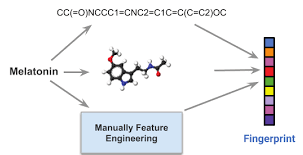

화합물의 이름이나 화학 공식을 그대로 활용하기는 어렵다. 따라서 화합물 데이터에 대해서 RDkit의 룰베이스 방식을 활용하여 벡터화해줄 것이다.


**자세한 내용은 아래 링크 참조하세요**

[RDkit](https://www.rdkit.org/docs/GettingStartedInPython.html)

[Molecular representations in AI-driven drug discovery: a review and practical guide](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00460-5)


[Extended-Connectivity Fingerprints](https://pubs.acs.org/doi/full/10.1021/ci100050tcasa_token=vsI6rp6l2RYAAAAA%3A_HTqMGypPZSQJnF4VqM4xl7KApBKMtKD1STnbh_EHOWeFOsfPKGETjY-SaiC-9XQtyhIEZHvGRRcMcEM)


In [14]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

def smiles2morgan(s, radius = 2, nBits = 1024):
    """SMILES data를 morgan fingerprint 데이터로 변환
       SMILES data가 뭐냐면? Simplified Molecular Input Line Entry System
       ex. CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1

    Args:
        s (str): SMILES of a drug
        radius (int): ECFP radius
        bBits (int): size of binary representation

    Return ():
        morgan fingerprint

    """
    try:
        mol = Chem.MolFromSmiles(s)
        features_vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        features = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(features_vec, features)
    except:
        print('rdkit not found this smiles for morgan: ' + s + ' convert to all 0 features')
        features = np.zeros((nBits, ))

    return features

In [15]:
# 전처리 함수 적용하기

for mode in ['train', 'valid', 'test']:
  rand_split[mode]['embedding'] = rand_split[mode]['Drug'].apply(smiles2morgan)

In [16]:
for mode in ['train', 'valid', 'test']:
  scaf_split[mode]['embedding'] = scaf_split[mode]['Drug'].apply(smiles2morgan)

**반드시 데이터를 확인하는 작업을 거친다**

In [17]:
# morgan fingerprint로 변환된 random split 데이터 확인
rand_split["test"]['embedding']

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
                               ...                        
61374    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61375    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61376    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61377    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
61378    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
Name: embedding, Length: 61379, dtype: object

In [18]:
# morgan fingerprint로 변환된 scaffold split 데이터 확인
scaf_split["test"]['embedding']

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
4        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
                               ...                        
61374    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61375    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61376    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61377    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
61378    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
Name: embedding, Length: 61379, dtype: object

# Torch Dataset & DataLoader 생성


In [19]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data

In [20]:
class data_process_loader(data.Dataset):
    """전처리한 데이터를 학습에 사용하기 위한 추상 클래스
    torch.utils.data.Dataset을 상속
    """
    def __init__(self, df):
        # 생성자
        # 앞서 전처리한 데이터 attribute에 저장
        self.df = df

    def __len__(self):
        # 전체 샘플 개수 출력을 위한 method
        return self.df.shape[0]

    def __getitem__(self, index):
        # 인덱스로 데이터에 접근하기 위한 method
        v_d = self.df.iloc[index]['embedding']  # input
        y = self.df.iloc[index]['Y'] # label

        return v_d, y

## Random Split Dataset, DataLoader 생성

In [21]:
rand_train_dataset = data_process_loader(rand_split["train"])
rand_valid_dataset = data_process_loader(rand_split["valid"])
rand_test_dataset = data_process_loader(rand_split["test"])

In [102]:
# DataLoader을 위한 hyperparameter 설정

params = {'batch_size': 512,
        'shuffle': True,
        'num_workers': 1,
        'drop_last': False}

In [103]:
rand_training_generator = data.DataLoader(rand_train_dataset, **params)
rand_valid_generator = data.DataLoader(rand_valid_dataset, **params)
rand_test_generator = data.DataLoader(rand_test_dataset, **params)

In [104]:
# DataLoader로 쌓인 데이터 확인해보기

for v_d, y in rand_training_generator:
    print(v_d)
    print(v_d.shape)
    print()
    print(y)
    print(y.shape)
    break

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
torch.Size([512, 1024])

tensor([  6.8764,  11.6311,  15.5813,  16.8240,   8.8095,   9.5182,  10.0118,
          6.7344,  13.6312,   9.2367,  -0.3509,   7.4228,   4.8807,  14.0831,
         -6.9034,  16.1118,  13.4460,   8.8593,   7.9350,  11.1437,   9.9088,
         13.6153,  11.0551,   8.9470,  14.5563,  10.2090,   5.6282,   7.1408,
         16.6558, -81.7118,   3.2223,  12.1312, -10.8340,   9.0067, -34.2178,
         11.9997,  12.1967,   9.9712,  11.5487,  15.2388,   1.3322,   9.2284,
         10.6938,  13.0948,  15.6639,  -0.7741,  10.6385,   1.1169,   4.6360,
         15.1744,  17.8902,  12.5341,  13.0055,   4.7485,   0.5645,   8.4781,
          2.5976,   3.2286,  16.0932,   1.5810,   1.4624,  10.5967,  -2.9157

## Scaffold Split Dataset, DataLoader 만들기


In [105]:
scaf_train_dataset = data_process_loader(scaf_split["train"])
scaf_valid_dataset = data_process_loader(scaf_split["valid"])
scaf_test_dataset = data_process_loader(scaf_split["test"])

In [106]:
scaf_training_generator = data.DataLoader(scaf_train_dataset, **params)
scaf_valid_generator = data.DataLoader(scaf_valid_dataset, **params)
scaf_test_generator = data.DataLoader(scaf_test_dataset, **params)

In [107]:
# DataLoader로 쌓인 데이터 확인해보기

for v_d, y in rand_training_generator:
    print(v_d)
    print(v_d.shape)
    print()
    print(y)
    print(y.shape)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
torch.Size([512, 1024])

tensor([ 1.1756e+01,  1.8245e+01, -9.2513e+00,  1.2880e+01,  1.2783e+01,
         7.3714e+00,  1.2120e+01, -7.4573e+00,  1.4923e+01,  1.8560e+01,
         4.9485e+00,  3.9909e+00,  1.4675e+01,  1.0198e+01,  8.2493e+00,
         5.2918e+00,  1.4146e+01,  6.5054e+00, -7.6401e+00,  4.3137e+00,
         1.5145e+00,  6.7607e+00,  1.6670e+00,  6.9918e+00,  2.8295e+00,
         8.8755e+00,  1.2390e+01,  2.9117e+00,  1.5480e+01,  1.1075e+01,
        -4.0664e+00,  1.3757e+01,  9.5719e+00, -1.8060e-01,  1.5441e+00,
         1.1614e+01,  6.4277e+00,  8.1810e+00, -7.0669e+00,  1.5284e+00,
         1.1146e+01,  1.1174e+01,  1.4834e+01, -1.8359e+00,  1.1089e+00,
        -5.7355e+00,  9.4062e+00,  7.4664e+

# Model 만들기


In [108]:
# Torch는 꼭 device 설정해주기
# 현재 colab free 제한으로 cpu 버전

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 device는 {device} 입니다.")

현재 device는 cuda 입니다.


## Feature Extractor

모델 하나하나 뜯어보기

In [109]:
class MLP(nn.Sequential):
	def __init__(self, input_dim, output_dim, hidden_dims_lst):
		'''Feature extractor
			Args:
				input_dim (int): 입력층 차원
				output_dim (int): 출력층 차원
				hidden_dims_lst (list): hidden 차원의 차원
		'''
		super(MLP, self).__init__()

		# Feature extractor layer size
		layer_size = len(hidden_dims_lst) + 1

		# 각 층의 차원 크기를 담은 리스트
		dims = [input_dim] + hidden_dims_lst + [output_dim]

		# 입력층, hidden 층, 출력층 차원대로 linear layer 쌓기
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v):
		# 입력 데이터 v로 forward pass
		v = v.float().to(device)
		for i, l in enumerate(self.predictor):
			v = F.relu(l(v))
		return v


## Classifier

In [110]:
class Classifier(nn.Sequential):
	def __init__(self, model_drug, hidden_dim_drug, cls_hidden_dims):
		'''Classifier
			Args:
				model_drug : 앞서 생성한 Feature extractor
				hidden_dim_drug (int): Classifier 입력층 차원
				cls_hidden_dims (list): Classifier hidden 차원
		'''
		super(Classifier, self).__init__()

		# feature extractor
		self.model_drug = model_drug

		# dropout
		self.dropout = nn.Dropout(0.1)

		# classifier 입력 차원
		self.input_dim_drug = hidden_dim_drug

		# classifier hidden 차원
		self.hidden_dims = cls_hidden_dims

		# classifier layer size
		layer_size = len(self.hidden_dims) + 1

		# 각 층의 차원 크기를 담은 리스트
		dims = [self.input_dim_drug] + self.hidden_dims + [1]

		# 입력층, hidden 층, 출력층 차원대로 linear layer 쌓기
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v_D):
		# feature extractor로 입력 데이터 encoding
		v_f = self.model_drug(v_D)

		# forword-pass with classify
		for i, l in enumerate(self.predictor):
			if i==(len(self.predictor)-1):
				v_f = l(v_f)
			else:
				v_f = F.relu(self.dropout(l(v_f)))
		return v_f

In [111]:
# 모델 hyperparameter

input_dim_drug = 1024
hidden_dim_drug = 256
cls_hidden_dims = [1024, 1024, 512]
mlp_hidden_dims_drug = [1024, 256, 64]

In [112]:
# 모델 선언하기
model_drug = MLP(input_dim_drug, hidden_dim_drug, mlp_hidden_dims_drug)

In [113]:
model_drug

MLP(
  (predictor): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=256, bias=True)
  )
)

In [114]:
model = Classifier(model_drug, hidden_dim_drug, cls_hidden_dims)

In [115]:
model

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

# Model Training

In [116]:
# 학습 진행에 필요한 hyperparameter

learning_rate = 0.0001
decay         = 0.00001
train_epoch   = 15

In [117]:
# optimizer

opt      = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = torch.nn.MSELoss()

In [118]:
# 라이브러리 호출
# !pip install numpy==1.24.0

import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index

## Random split DataLoader로 훈련시키기

In [119]:
loss_history = []

max_MSE = 10000

# 모델 GPU 메모리에 올리기
rand_model = model.to(device)

# Best 모델 초기화
rand_model_max = copy.deepcopy(rand_model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록
t_start = time()

for epo in range(train_epoch):
    # Model training
    rand_model.train()

    # Mini-batch 학습
    for i, (v_d, label) in enumerate(rand_training_generator):
        # input data gpu에 올리기
        v_d = v_d.float().to(device)
        # forward-pass
        score = rand_model(v_d)

        n = torch.squeeze(score, 1)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
        loss = loss_fn(n.float(), label.float().to(device))

        # 각 iteration 마다 loss 기록
        loss_history.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()

    # gradient tracking X
    with torch.set_grad_enabled(False):

        y_pred = []
        y_label = []
        # model validation
        rand_model.eval()

        for i, (v_d, label) in enumerate(rand_valid_generator):
            # validation 입력 데이터 gpu에 올리기
            v_d = v_d.float().to(device)

            # forward-pass
            score = rand_model(v_d)

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            logits = torch.squeeze(score).cpu().numpy()
            label_ids = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label_ids.flatten().tolist()
            y_pred = y_pred + logits.flatten().tolist()

    # metric 계산
    mse = mean_squared_error(y_label, y_pred) # MSE
    r2 = pearsonr(y_label, y_pred)[0] # Pearson correlation coefficient
    p_val = pearsonr(y_label, y_pred)[1] # Pearson correlation p-value
    CI =  concordance_index(y_label, y_pred) # CI

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)

    # mse 기준으로 best model 업데이트
    if mse < max_MSE:
        # best model deepcopy
        rand_model_max = copy.deepcopy(rand_model)
        # max MSE 업데이트
        max_MSE = mse

    # 각 epoch 마다 결과 출력
    print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])


--- Go for Training ---
Validation at Epoch 1 , MSE: 101.676 , Pearson Correlation: 0.40702 with p-value: 0.00E+00 , Concordance Index: 0.57629
Validation at Epoch 2 , MSE: 94.7738 , Pearson Correlation: 0.47678 with p-value: 0.00E+00 , Concordance Index: 0.58153
Validation at Epoch 3 , MSE: 91.6488 , Pearson Correlation: 0.49833 with p-value: 0.00E+00 , Concordance Index: 0.58542
Validation at Epoch 4 , MSE: 91.4637 , Pearson Correlation: 0.51087 with p-value: 0.00E+00 , Concordance Index: 0.58937
Validation at Epoch 5 , MSE: 90.1731 , Pearson Correlation: 0.51879 with p-value: 0.00E+00 , Concordance Index: 0.59156
Validation at Epoch 6 , MSE: 90.2190 , Pearson Correlation: 0.52243 with p-value: 0.00E+00 , Concordance Index: 0.59204
Validation at Epoch 7 , MSE: 89.6804 , Pearson Correlation: 0.52109 with p-value: 0.00E+00 , Concordance Index: 0.59070
Validation at Epoch 8 , MSE: 90.1736 , Pearson Correlation: 0.52003 with p-value: 0.00E+00 , Concordance Index: 0.59238
Validation at Ep

## random split data로 훈련한 model testing

In [120]:
# Test 진행할 데이터 확인
for i, (v_d, label) in enumerate(rand_test_dataset):
    print(v_d)
    print(label)
    break

[0. 0. 0. ... 0. 0. 0.]
9.7453


In [121]:
# 테스트 진행

rand_y_pred = []
rand_y_label = []

rand_model.eval()
for i, (v_d, label) in enumerate(rand_test_generator):
    # input data gpu에 올리기
    v_d = v_d.float().to(device)

    # forward-pass
    score = rand_model(v_d)

    # 예측값 gradient graph detach -> cpu로 옮기기 -> numpy 형으로 변환
    logits = torch.squeeze(score).detach().cpu().numpy()

    # 참값 cpu로 옮기고 numpy 형으로 변환
    label_ids = label.cpu().numpy()

    # 예측값, 참값 기록
    rand_y_label = rand_y_label + label_ids.flatten().tolist()
    rand_y_pred = rand_y_pred + logits.flatten().tolist()

# metric 계산
rand_mse = mean_squared_error(rand_y_label, rand_y_pred)
rand_r2 = pearsonr(rand_y_label, rand_y_pred)[0]
rand_p_val = pearsonr(rand_y_label, rand_y_pred)[1]
rand_CI =  concordance_index(rand_y_label, rand_y_pred)

print('TestSet Performence Metric '+  ' , MSE: ' + str(rand_mse)[:7] + ' , Pearson Correlation: '\
        + str(rand_r2)[:7] + ' with p-value: ' + str(f"{rand_p_val:.2E}") +' , Concordance Index: '+str(rand_CI)[:7])

TestSet Performence Metric  , MSE: 99.6747 , Pearson Correlation: 0.51322 with p-value: 0.00E+00 , Concordance Index: 0.58642


## Scaffold Split DataLoader로 훈련시키기


In [122]:
loss_history = []

max_MSE = 10000

# 모델 GPU 메모리에 올리기
scaf_model = model.to(device)

# Best 모델 초기화
scaf_model_max = copy.deepcopy(scaf_model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록
t_start = time()

for epo in range(train_epoch):
    # Model training
    scaf_model.train()

    # Mini-batch 학습
    for i, (v_d, label) in enumerate(scaf_training_generator):
        # input data gpu에 올리기
        v_d = v_d.float().to(device)
        # forward-pass
        score = scaf_model(v_d)

        n = torch.squeeze(score, 1)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
        loss = loss_fn(n.float(), label.float().to(device))

        # 각 iteration 마다 loss 기록
        loss_history.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()

    # gradient tracking X
    with torch.set_grad_enabled(False):

        y_pred = []
        y_label = []
        # model validation
        scaf_model.eval()

        for i, (v_d, label) in enumerate(scaf_valid_generator):
            # validation 입력 데이터 gpu에 올리기
            v_d = v_d.float().to(device)

            # forward-pass
            score = scaf_model(v_d)

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            logits = torch.squeeze(score).cpu().numpy()
            label_ids = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label_ids.flatten().tolist()
            y_pred = y_pred + logits.flatten().tolist()

    # metric 계산
    mse = mean_squared_error(y_label, y_pred) # MSE
    r2 = pearsonr(y_label, y_pred)[0] # Pearson correlation coefficient
    p_val = pearsonr(y_label, y_pred)[1] # Pearson correlation p-value
    CI =  concordance_index(y_label, y_pred) # CI

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)

    # mse 기준으로 best model 업데이트
    if mse < max_MSE:
        # best model deepcopy
        scaf_model_max = copy.deepcopy(scaf_model)
        # max MSE 업데이트
        max_MSE = mse

    # 각 epoch 마다 결과 출력
    print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])


--- Go for Training ---
Validation at Epoch 1 , MSE: 55.6544 , Pearson Correlation: 0.75311 with p-value: 0.00E+00 , Concordance Index: 0.67914
Validation at Epoch 2 , MSE: 56.4256 , Pearson Correlation: 0.75155 with p-value: 0.00E+00 , Concordance Index: 0.67676
Validation at Epoch 3 , MSE: 57.7646 , Pearson Correlation: 0.74597 with p-value: 0.00E+00 , Concordance Index: 0.67267
Validation at Epoch 4 , MSE: 58.7691 , Pearson Correlation: 0.74141 with p-value: 0.00E+00 , Concordance Index: 0.67082
Validation at Epoch 5 , MSE: 60.4476 , Pearson Correlation: 0.73324 with p-value: 0.00E+00 , Concordance Index: 0.66723
Validation at Epoch 6 , MSE: 61.2165 , Pearson Correlation: 0.72883 with p-value: 0.00E+00 , Concordance Index: 0.66423
Validation at Epoch 7 , MSE: 62.9791 , Pearson Correlation: 0.72475 with p-value: 0.00E+00 , Concordance Index: 0.66110
Validation at Epoch 8 , MSE: 62.3482 , Pearson Correlation: 0.72063 with p-value: 0.00E+00 , Concordance Index: 0.65612
Validation at Ep

## scaffold split data로 훈련한 model testing

In [123]:
# Test 진행할 데이터 확인
for i, (v_d, label) in enumerate(scaf_test_dataset):
    print(v_d)
    print(label)
    break

[0. 0. 0. ... 0. 0. 0.]
7.5783


In [124]:
# 테스트 진행

scaf_y_pred = []
scaf_y_label = []

scaf_model.eval()
for i, (v_d, label) in enumerate(scaf_test_generator):
    # input data gpu에 올리기
    v_d = v_d.float().to(device)

    # forward-pass
    score = scaf_model(v_d)

    # 예측값 gradient graph detach -> cpu로 옮기기 -> numpy 형으로 변환
    logits = torch.squeeze(score).detach().cpu().numpy()

    # 참값 cpu로 옮기고 numpy 형으로 변환
    label_ids = label.cpu().numpy()

    # 예측값, 참값 기록
    scaf_y_label = scaf_y_label + label_ids.flatten().tolist()
    scaf_y_pred = scaf_y_pred + logits.flatten().tolist()

# metric 계산
scaf_mse = mean_squared_error(scaf_y_label, scaf_y_pred)
scaf_r2 = pearsonr(scaf_y_label, scaf_y_pred)[0]
scaf_p_val = pearsonr(scaf_y_label, scaf_y_pred)[1]
scaf_CI =  concordance_index(scaf_y_label, scaf_y_pred)

print('TestSet Performence Metric '+  ' , MSE: ' + str(scaf_mse)[:7] + ' , Pearson Correlation: '\
        + str(scaf_r2)[:7] + ' with p-value: ' + str(f"{scaf_p_val:.2E}") +' , Concordance Index: '+str(scaf_CI)[:7])

TestSet Performence Metric  , MSE: 72.9206 , Pearson Correlation: 0.68363 with p-value: 0.00E+00 , Concordance Index: 0.64268


# Testing result visualization

## Random split data result visualization


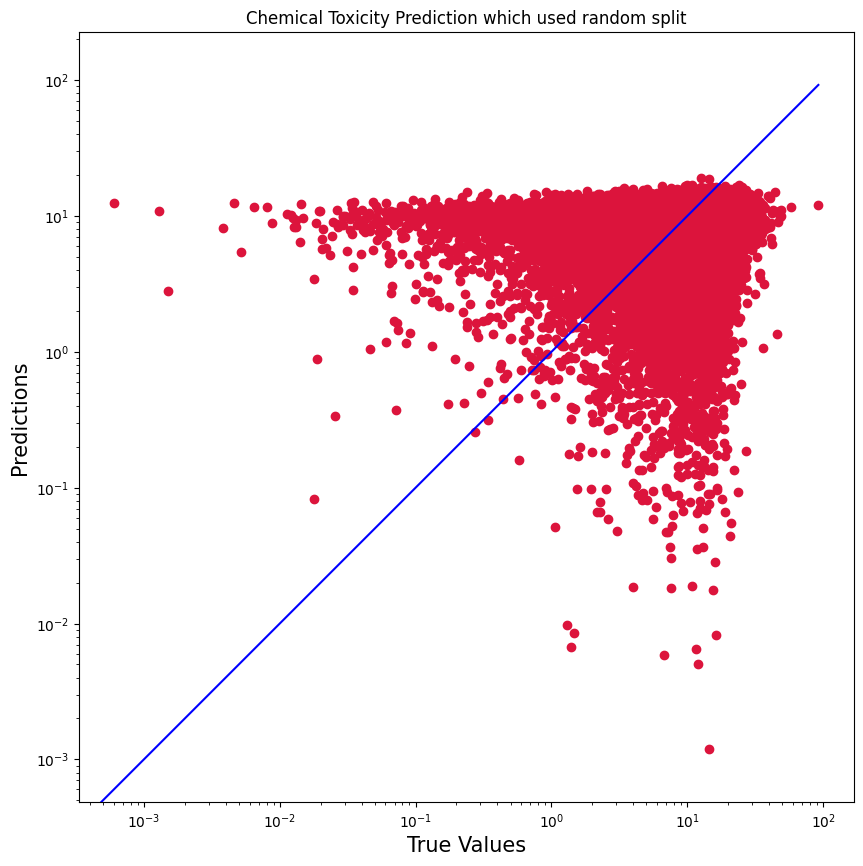

In [125]:
# 최종 테스트 결과 시각화
import matplotlib.pyplot as plt

# 참값 ~ 예측값 scatter plot
plt.figure(figsize=(10,10))
plt.scatter(rand_y_label, rand_y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(rand_y_pred), max(rand_y_label))
p2 = min(min(rand_y_pred), min(rand_y_label))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Chemical Toxicity Prediction which used random split')
plt.show()

## Scaffold split data result visualization

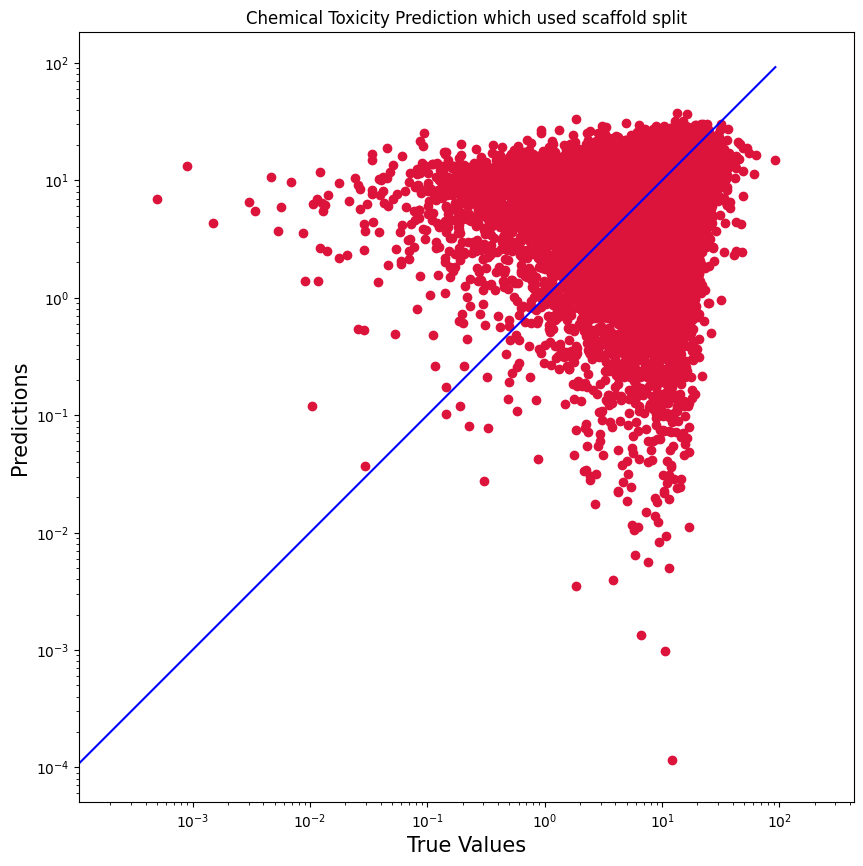

In [126]:
# 최종 테스트 결과 시각화
import matplotlib.pyplot as plt

# 참값 ~ 예측값 scatter plot
plt.figure(figsize=(10,10))
plt.scatter(scaf_y_label, scaf_y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(scaf_y_pred), max(scaf_y_label))
p2 = min(min(scaf_y_pred), min(scaf_y_label))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Chemical Toxicity Prediction which used scaffold split')
plt.show()

## Random Split 방식 결과
MSE (Mean Squared Error): 99.6747

Pearson Correlation: 0.51322 with p-value: 0.00E+00

Concordance Index: 0.58642

## Scaffold Split 방식 결과
MSE (Mean Squared Error): 72.9206

Pearson Correlation: 0.68363 with p-value: 0.00E+00

Concordance Index: 0.64268


## 요약

성능 지표:  Scaffold Split 방식이 Random Split 방식보다 MSE가 낮고, Pearson Correlation과 Concordance Index가 높아 더 좋은 성능을 보였습니다.

Scaffold Split 방식이 모델의 성능 평가에서 더 나은 결과를 보이고 있지만, 실제 사용 상황에서의 일반화 성능을 평가하기 위해서는 Random Split 방식도 중요한 지표가 될 수 있습니다. 이는 모델이 새로운 데이터에서의 성능을 얼마나 잘 발휘하는지를 평가하는 데 도움이 됩니다.